# Posterior predictive checks

See Appendix C for explanation. Here we calculate the case for the fit to the joint simulation in `arrival_vs_joint/`, but the procedure is the same for the fits to data. 
<br>
<br>
*This code is used to produce the figures displayed in Figure C1 of Capel & Mortlock (2019).*

In [11]:
import numpy as np
import stan_utility

from fancy import Results

In [12]:
# Define the fit file
sim_fit_file = '../3_fits_to_simulations/arrival_vs_joint/output/joint_fit.h5'
results = Results(sim_fit_file)

# Define the Stan model for PPCs
stan_path = '../stan/'
ppc_sim = stan_path + 'joint_model_ppc.stan'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# Define the output file
ppc_output = 'output/ppc.h5'

# For reproducible results
random_seed = 19920715

In [13]:
N = 10
# N = 100 # used in paper

results.run_ppc(ppc_sim, stan_path, N = N, seed = random_seed)
results.ppc.save(ppc_output)

Using cached StanModel
Precomputing exposure integral: 100%|██████████| 23/23 [00:54<00:00,  2.38s/it]

Precomputing exposure integral:   0%|          | 0/23 [00:00<?, ?it/s]

Precomputing exposure integral: 100%|██████████| 23/23 [00:56<00:00,  2.44s/it]

Precomputing exposure integral: 100%|██████████| 23/23 [00:56<00:00,  2.46s/it]

Precomputing exposure integral:   0%|          | 0/23 [00:00<?, ?it/s]

Precomputing exposure integral: 100%|██████████| 23/23 [00:55<00:00,  2.42s/it]

Precomputing exposure integral: 100%|██████████| 23/23 [00:55<00:00,  2.43s/it]

Precomputing exposure integral: 100%|██████████| 23/23 [00:55<00:00,  2.41s/it]

Precomputing exposure integral:   0%|          | 0/23 [00:00<?, ?it/s]

Precomputing exposure integral: 100%|██████████| 23/23 [00:53<00:00,  2.34s/it]

Posterior predictive simulation(s): 100%|██████████| 10/10 [09:32<00:00, 57.29s/it]


## Plot the results

In [14]:
import h5py
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('minimalist')

from fancy import Data
from fancy.plotting import AllSkyMap
from fancy.plotting.colours import purple, grey
from fancy.interfaces.stan import Direction

In [15]:
# Choose catalogue
title = 'Simulation'
color = purple

# Read in PPC
with h5py.File(ppc_output, 'r') as f:
    
    # Energy
    Edet = f['PPC/Edet'][()]
    Edet_preds = f['PPC/Edet_preds'][()]
    
    # Arrival direction
    arrival_direction = Direction(f['PPC/arrival_direction'][()])
    arr_dir_preds = []
    for i in range(len(Edet_preds)):
        arr_dir_preds.append(f['PPC/arrival_direction_preds/'+str(i)][()])
    arrival_direction_pred = [Direction(a) for a in arr_dir_preds]

### Energy

In [16]:
# Energy bins
bins = np.logspace(np.log(52), np.log(1e3), 50, base = np.e)

# Legend
legend_elements = [Line2D([0], [0], color = color, label = '$\hat{E}$', 
                          lw = 3, alpha = 1),
                   Line2D([0], [0], color = grey, label = '$\hat{E}_\mathrm{rep}$', 
                          lw = 3, alpha = 1),]

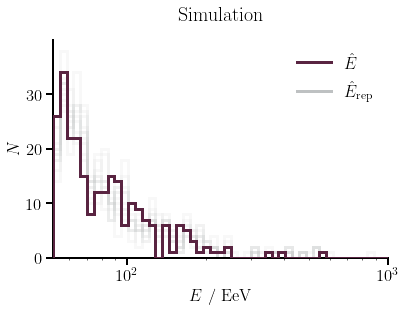

In [17]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

ax.hist(Edet, bins = bins, color = color, histtype = 'step', lw = 3, zorder = 5)
for E in Edet_preds:
    ax.hist(E, bins= bins, color = grey, histtype = 'step', lw = 3, alpha = 0.1)

ax.set_xscale('log')
ax.set_xlim(52, 1.0e3)
ax.set_xlabel('$E$ / EeV')
ax.set_ylabel('$N$')
ax.legend(handles = legend_elements)
ax.set_title(title, pad = 20, fontsize = 20);

## Arrival directions

In [18]:
from fancy.detector.auger2014 import detector_properties

In [19]:
data = Data()
data.add_detector(detector_properties)
limiting_dec = data.detector.limiting_dec.deg

# Legend
legend_elements = [Line2D([0], [0], marker='o', color = 'w', label = '$\hat{\omega}$', 
                          markersize = 10, markerfacecolor = color, alpha = 1),
                   Line2D([0], [0], marker='o', color='w', 
                          label='$\hat{\omega}_\mathrm{rep}$', 
                          markersize = 10, markerfacecolor = grey, alpha = 1)]

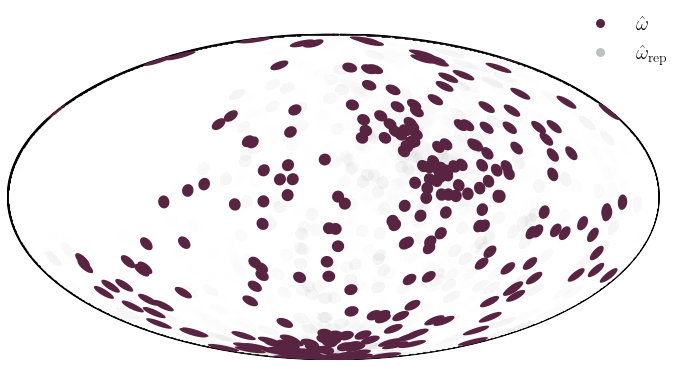

In [20]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# UHECR data
for lon, lat in np.nditer([arrival_direction.lons, arrival_direction.lats]):
        skymap.tissot(lon, lat, 3, 30,
                      facecolor = color, alpha = 1, zorder = 10)
        
# Predicted UHECR
for adp in arrival_direction_pred:
    for lon, lat, dec in np.nditer([adp.lons, adp.lats, adp.d.dec]):
        if (dec < limiting_dec):
            skymap.tissot(lon, lat, 3, 30,
                          facecolor = grey, alpha = 0.01, zorder = 5)
            
# Annotate
skymap.draw_border()
ax.legend(handles = legend_elements, bbox_to_anchor = (0.85, 0.85), fontsize = 20);